# This code was designed to prove that we can make an estimator that works for an arbitrary function

# This code is meant to be run by Tensorflow 2.0 under Conda, the conda environment creating file is provided in the base folder of this repository

## The cell bellow suppresses the warnings from tf and other packages that are overly verbose

In [1]:
import warnings
warnings.filterwarnings('ignore')

## The imports are self explanatory

In [2]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Layer, Input
from keras import optimizers
from sklearn.metrics import r2_score
import gc
import os

Using TensorFlow backend.


# <span style="color:red">This function has been changed to a gaussian version of itself to test the generalization properties of the network</span>
## This function generates the dataset points for the test, feel free to modify it as you wish to see if the network can still fit it

In [3]:
f1 = lambda z,c,v: 1/(1 + np.exp((-z+c)*v))

In [4]:
f2 = lambda q,w,e: f1(q,w,e) + f1(q,-w,-e)

In [5]:
def generatePointsGaussian(vector_size,samples,deviation = 0.2):
    x = np.linspace(-np.pi*3/2,np.pi*3/2,vector_size)
    x_grid = np.array(np.meshgrid(x,x,sparse=False))
    x_grid = np.array(x_grid.transpose((2,1,0)))
    x_grid = x_grid.reshape(x_grid.shape[0]*x_grid.shape[1],2)
    xmatrix = []
    ymatrix = []
    for i in range(samples):
        ymatrix.append(np.zeros(len(x_grid)))
        xmatrix.append(x_grid)
    xvector = np.array(xmatrix).reshape(((vector_size**2)*samples,2))
    yvector = np.array(ymatrix).reshape(((vector_size**2)*samples,))
    for j in range(0,len(xvector)):
            deviationNow = deviation*f2(abs((xvector[j,0]/(np.pi*3/2))),0.2,35)
            yvector[j] = np.cos(xvector[j,0])*np.cos(xvector[j,1]) + np.random.normal(scale = deviationNow)
    return xvector,yvector

## This cell and the graph bellow are here as debug, showing how the function works

In [6]:
generatePointsGaussian(5,2)[0][:,1]

array([-4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898,
       -4.71238898, -2.35619449,  0.        ,  2.35619449,  4.71238898])

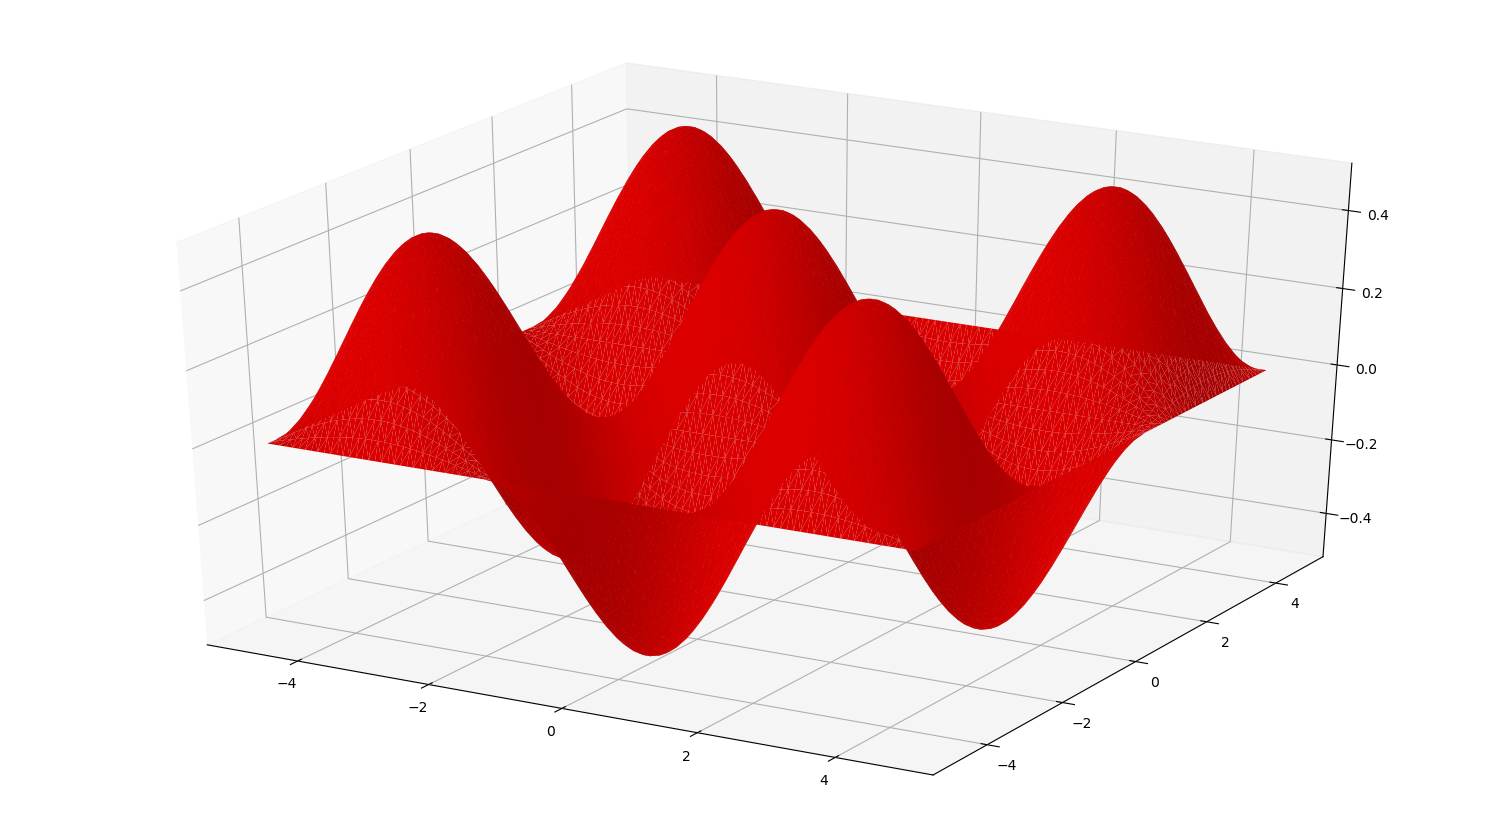

In [7]:
fig = plt.figure(figsize=(19.20,10.80),dpi=100)
ax = fig.add_subplot(111, projection='3d')
pointesx, pointesy = generatePointsGaussian(100,1,0)
#ax.scatter(pointesx[:,0],pointesx[:,1],pointesy,color='r')
ax.plot_trisurf(pointesx[:,0],pointesx[:,1],0.5*pointesy,color='r')
#ax.set_title("Original Function")
#fig.savefig(f"../videos/tmp/original.png")

## This function bellow will be the cost function for the mixture density network

In [8]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

## The neural network model bellow implements a simple neural network with fully connected layers that fits the data

In [9]:
xInputLayer = Input(shape=(2,))
yInputLayer = Input(shape=(1,))
layer1 = Dense(400,activation="sigmoid")(xInputLayer)
layer2 = Dense(400,activation="sigmoid")(layer1)
layer3 = Dense(400,activation="sigmoid")(layer2)
mu = Dense(1,activation="linear")(layer3)
sigma = Dense(1,activation = lambda x: tf.nn.elu(x)+1)(layer3)
lossFunction = mdn_cost(mu,sigma,yInputLayer)
model = Model(inputs=[xInputLayer,yInputLayer], outputs=[mu,sigma])
model.add_loss(lossFunction)
adamOptimizer = optimizers.Adam(learning_rate=0.00003,beta_1=0.7,beta_2=0.9)
adagradOptimizer  = optimizers.Adagrad()
sgdOptimizer  = optimizers.SGD()
model.compile(optimizer=adamOptimizer,metrics=['mse'])


In [10]:
def generatePoints(vector_size):
    x = np.zeros(vector_size)
    y = np.zeros(vector_size)
    for i in range(0,len(x)):
        x[i] = np.random.random()*np.pi*3 - np.pi*3/2
        y[i] = np.cos(x[i])
    return x,y

## Generate the data that will be used in the training and testing of the model

In [11]:
xtrain, ytrain = generatePointsGaussian(120,10,deviation=0.1)

In [12]:
x_test = np.linspace(-np.pi*3/2,np.pi*3/2,100)
x_test_grid = np.array(np.meshgrid(x_test,x_test,sparse=False))
x_test_grid = np.array(x_test_grid.transpose((2,1,0)))
x_test_grid = x_test_grid.reshape(x_test_grid.shape[0]*x_test_grid.shape[1],2)
originalFunction = np.cos(x_test_grid[:,0])*np.cos(x_test_grid[:,1])

In [13]:
class generateImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            mu_pred, sigma_pred = model.predict(list((x_test_grid,x_test_grid[:,0]))) # the model expects a list of arrays as it has 2 inputs
            figtmp = plt.figure(figsize=(19.20,10.80),dpi=100)
            ax = figtmp.add_subplot(111, projection='3d')
            pointesx, pointesy = generatePointsGaussian(100,1,0)
            ax.plot_trisurf(x_test_grid[:,0],x_test_grid[:,1],mu_pred.reshape(mu_pred.shape[0],))
            ax.set_zlim(-1.3,1.3)
            ax.view_init(30,(360/3000)*epoch*2)
            r2 = r2_score(originalFunction,mu_pred[:,0])
            ax.set_title("R²: "+ str(r2))
            figtmp.savefig(f"../videos/tmp/img{epoch:03d}.png")
            figtmp.clf()
            plt.close(figtmp)
            gc.collect()

## The training phase is logged to a cache that is used bellow to show the network's progress over the epochs of training

In [14]:
history_cache = model.fit([xtrain, ytrain],
                          epochs=3000,
                          batch_size=10000,
                          validation_split=0.2,
                          verbose = 1,
                          #callbacks = [generateImages()]
                         )

Train on 115200 samples, validate on 28800 samples
Epoch 1/3000
115200/115200 [==============================] - 1s 11us/step - loss: 0.9260 - val_loss: 0.7293
Epoch 2/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7298 - val_loss: 0.7281
Epoch 3/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7293 - val_loss: 0.7278
Epoch 4/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7278
Epoch 5/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7278
Epoch 6/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7293 - val_loss: 0.7280
Epoch 7/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7293 - val_loss: 0.7277
Epoch 8/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7279
Epoch 9/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.

115200/115200 [==============================] - 0s 2us/step - loss: 0.7291 - val_loss: 0.7278
Epoch 76/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7279
Epoch 77/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7277
Epoch 78/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7293 - val_loss: 0.7276
Epoch 79/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7290 - val_loss: 0.7279
Epoch 80/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7291 - val_loss: 0.7280
Epoch 81/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7277
Epoch 82/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7291 - val_loss: 0.7276
Epoch 83/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7279
Epoch 84/3000
115200/115200 [====

Epoch 150/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7289 - val_loss: 0.7276
Epoch 151/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7290 - val_loss: 0.7278
Epoch 152/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7289 - val_loss: 0.7282
Epoch 153/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7290 - val_loss: 0.7297
Epoch 154/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7292 - val_loss: 0.7274
Epoch 155/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7289 - val_loss: 0.7278
Epoch 156/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7291 - val_loss: 0.7278
Epoch 157/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7291 - val_loss: 0.7276
Epoch 158/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7290 - val_loss: 0.7274
Epoch 159/

115200/115200 [==============================] - 0s 2us/step - loss: 0.7284 - val_loss: 0.7268
Epoch 225/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7284 - val_loss: 0.7276
Epoch 226/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7287 - val_loss: 0.7273
Epoch 227/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7283 - val_loss: 0.7282
Epoch 228/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7288 - val_loss: 0.7268
Epoch 229/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7282 - val_loss: 0.7268
Epoch 230/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7283 - val_loss: 0.7271
Epoch 231/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7282 - val_loss: 0.7273
Epoch 232/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7285 - val_loss: 0.7269
Epoch 233/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.7262 - val_loss: 0.7246
Epoch 299/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7261 - val_loss: 0.7246
Epoch 300/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7260 - val_loss: 0.7245
Epoch 301/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7260 - val_loss: 0.7245
Epoch 302/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7261 - val_loss: 0.7244
Epoch 303/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7259 - val_loss: 0.7243
Epoch 304/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7259 - val_loss: 0.7245
Epoch 305/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7257 - val_loss: 0.7242
Epoch 306/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7257 - val_loss: 0.7241
Epoch 307/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.7171 - val_loss: 0.7158
Epoch 373/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7169 - val_loss: 0.7159
Epoch 374/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7167 - val_loss: 0.7150
Epoch 375/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7164 - val_loss: 0.7148
Epoch 376/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7165 - val_loss: 0.7147
Epoch 377/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7160 - val_loss: 0.7145
Epoch 378/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7159 - val_loss: 0.7146
Epoch 379/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7158 - val_loss: 0.7140
Epoch 380/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.7155 - val_loss: 0.7143
Epoch 381/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.6952 - val_loss: 0.6936
Epoch 447/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6949 - val_loss: 0.6939
Epoch 448/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6948 - val_loss: 0.6938
Epoch 449/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6943 - val_loss: 0.6925
Epoch 450/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6939 - val_loss: 0.6921
Epoch 451/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6937 - val_loss: 0.6919
Epoch 452/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6933 - val_loss: 0.6915
Epoch 453/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6928 - val_loss: 0.6913
Epoch 454/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6925 - val_loss: 0.6909
Epoch 455/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.6706 - val_loss: 0.6688
Epoch 521/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6702 - val_loss: 0.6696
Epoch 522/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6701 - val_loss: 0.6687
Epoch 523/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6700 - val_loss: 0.6680
Epoch 524/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6695 - val_loss: 0.6675
Epoch 525/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6692 - val_loss: 0.6673
Epoch 526/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6688 - val_loss: 0.6678
Epoch 527/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6688 - val_loss: 0.6667
Epoch 528/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6683 - val_loss: 0.6664
Epoch 529/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.6467 - val_loss: 0.6448
Epoch 595/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6463 - val_loss: 0.6444
Epoch 596/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6460 - val_loss: 0.6441
Epoch 597/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6455 - val_loss: 0.6435
Epoch 598/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6450 - val_loss: 0.6431
Epoch 599/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6445 - val_loss: 0.6433
Epoch 600/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6444 - val_loss: 0.6422
Epoch 601/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6437 - val_loss: 0.6418
Epoch 602/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6434 - val_loss: 0.6412
Epoch 603/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.6013 - val_loss: 0.6010
Epoch 669/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.6008 - val_loss: 0.5982
Epoch 670/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5997 - val_loss: 0.5974
Epoch 671/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5990 - val_loss: 0.5963
Epoch 672/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5979 - val_loss: 0.5956
Epoch 673/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5972 - val_loss: 0.5946
Epoch 674/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5962 - val_loss: 0.5954
Epoch 675/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5955 - val_loss: 0.5934
Epoch 676/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5945 - val_loss: 0.5928
Epoch 677/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.5055 - val_loss: 0.5028
Epoch 743/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5037 - val_loss: 0.5001
Epoch 744/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.5018 - val_loss: 0.4984
Epoch 745/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4999 - val_loss: 0.4966
Epoch 746/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4980 - val_loss: 0.4952
Epoch 747/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4963 - val_loss: 0.4942
Epoch 748/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4946 - val_loss: 0.4911
Epoch 749/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4926 - val_loss: 0.4890
Epoch 750/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.4904 - val_loss: 0.4869
Epoch 751/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.3699 - val_loss: 0.3662
Epoch 817/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3684 - val_loss: 0.3666
Epoch 818/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3670 - val_loss: 0.3634
Epoch 819/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3652 - val_loss: 0.3612
Epoch 820/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3636 - val_loss: 0.3596
Epoch 821/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3621 - val_loss: 0.3584
Epoch 822/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3607 - val_loss: 0.3567
Epoch 823/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3591 - val_loss: 0.3557
Epoch 824/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.3576 - val_loss: 0.3536
Epoch 825/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.2755 - val_loss: 0.2715
Epoch 891/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2746 - val_loss: 0.2715
Epoch 892/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2735 - val_loss: 0.2735
Epoch 893/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2728 - val_loss: 0.2691
Epoch 894/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2715 - val_loss: 0.2675
Epoch 895/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2703 - val_loss: 0.2672
Epoch 896/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2693 - val_loss: 0.2654
Epoch 897/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2687 - val_loss: 0.2648
Epoch 898/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.2672 - val_loss: 0.2637
Epoch 899/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.1975 - val_loss: 0.1948
Epoch 965/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1966 - val_loss: 0.1924
Epoch 966/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1956 - val_loss: 0.1918
Epoch 967/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1941 - val_loss: 0.1904
Epoch 968/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1930 - val_loss: 0.1890
Epoch 969/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1921 - val_loss: 0.1886
Epoch 970/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1912 - val_loss: 0.1869
Epoch 971/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1898 - val_loss: 0.1860
Epoch 972/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1888 - val_loss: 0.1849
Epoch 973/3000
115200/115

115200/115200 [==============================] - 0s 2us/step - loss: 0.1083 - val_loss: 0.1040
Epoch 1039/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1072 - val_loss: 0.1021
Epoch 1040/3000
115200/115200 [==============================] - 0s 3us/step - loss: 0.1058 - val_loss: 0.1008
Epoch 1041/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1041 - val_loss: 0.0996
Epoch 1042/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1026 - val_loss: 0.0997
Epoch 1043/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.1012 - val_loss: 0.0988
Epoch 1044/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.0997 - val_loss: 0.0950
Epoch 1045/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.0982 - val_loss: 0.0932
Epoch 1046/3000
115200/115200 [==============================] - 0s 2us/step - loss: 0.0963 - val_loss: 0.0920
Epoch 1047/3000
1

115200/115200 [==============================] - 0s 3us/step - loss: -0.0231 - val_loss: -0.0288
Epoch 1112/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.0258 - val_loss: -0.0317
Epoch 1113/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.0285 - val_loss: -0.0323
Epoch 1114/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.0307 - val_loss: -0.0344
Epoch 1115/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.0333 - val_loss: -0.0390
Epoch 1116/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.0356 - val_loss: -0.0418
Epoch 1117/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.0386 - val_loss: -0.0446
Epoch 1118/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.0411 - val_loss: -0.0456
Epoch 1119/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.0439 - val_loss: -0.0499

115200/115200 [==============================] - 0s 3us/step - loss: -0.2671 - val_loss: -0.2754
Epoch 1184/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2717 - val_loss: -0.2787
Epoch 1185/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2767 - val_loss: -0.2828
Epoch 1186/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.2796 - val_loss: -0.2869
Epoch 1187/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2842 - val_loss: -0.2911
Epoch 1188/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2880 - val_loss: -0.2939
Epoch 1189/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2928 - val_loss: -0.2967
Epoch 1190/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.2963 - val_loss: -0.3034
Epoch 1191/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.3012 - val_loss: -0.3046

115200/115200 [==============================] - 0s 3us/step - loss: -0.4981 - val_loss: -0.5016
Epoch 1256/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5002 - val_loss: -0.5046
Epoch 1257/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.5031 - val_loss: -0.5069
Epoch 1258/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5035 - val_loss: -0.5051
Epoch 1259/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5070 - val_loss: -0.5071
Epoch 1260/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5079 - val_loss: -0.5116
Epoch 1261/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5098 - val_loss: -0.5068
Epoch 1262/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5113 - val_loss: -0.5160
Epoch 1263/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.5132 - val_loss: -0.5159

115200/115200 [==============================] - 0s 3us/step - loss: -0.6151 - val_loss: -0.6184
Epoch 1328/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6168 - val_loss: -0.6173
Epoch 1329/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.6177 - val_loss: -0.6161
Epoch 1330/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6169 - val_loss: -0.6222
Epoch 1331/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6215 - val_loss: -0.6234
Epoch 1332/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6231 - val_loss: -0.6214
Epoch 1333/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6240 - val_loss: -0.6258
Epoch 1334/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6259 - val_loss: -0.6292
Epoch 1335/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.6256 - val_loss: -0.6249

115200/115200 [==============================] - 0s 3us/step - loss: -0.7165 - val_loss: -0.7218
Epoch 1400/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7210 - val_loss: -0.7172
Epoch 1401/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7205 - val_loss: -0.7252
Epoch 1402/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7222 - val_loss: -0.7266
Epoch 1403/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7225 - val_loss: -0.7277
Epoch 1404/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.7252 - val_loss: -0.7278
Epoch 1405/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7268 - val_loss: -0.7303
Epoch 1406/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.7267 - val_loss: -0.7227
Epoch 1407/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.7286 - val_loss: -0.7332

115200/115200 [==============================] - 0s 2us/step - loss: -0.8057 - val_loss: -0.7897
Epoch 1472/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8034 - val_loss: -0.8089
Epoch 1473/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8068 - val_loss: -0.8074
Epoch 1474/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8073 - val_loss: -0.8080
Epoch 1475/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8106 - val_loss: -0.8112
Epoch 1476/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8110 - val_loss: -0.8155
Epoch 1477/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8096 - val_loss: -0.8132
Epoch 1478/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8130 - val_loss: -0.8044
Epoch 1479/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8142 - val_loss: -0.8189

115200/115200 [==============================] - 0s 3us/step - loss: -0.8749 - val_loss: -0.8713
Epoch 1544/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8765 - val_loss: -0.8812
Epoch 1545/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8732 - val_loss: -0.8836
Epoch 1546/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8791 - val_loss: -0.8843
Epoch 1547/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8780 - val_loss: -0.8851
Epoch 1548/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8801 - val_loss: -0.8862
Epoch 1549/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.8826 - val_loss: -0.8812
Epoch 1550/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8795 - val_loss: -0.8811
Epoch 1551/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.8834 - val_loss: -0.8886

115200/115200 [==============================] - 0s 3us/step - loss: -0.9372 - val_loss: -0.9306
Epoch 1616/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9318 - val_loss: -0.9371
Epoch 1617/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9365 - val_loss: -0.9379
Epoch 1618/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9367 - val_loss: -0.9428
Epoch 1619/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9404 - val_loss: -0.9436
Epoch 1620/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.9320 - val_loss: -0.9417
Epoch 1621/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9398 - val_loss: -0.9437
Epoch 1622/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.9407 - val_loss: -0.9429
Epoch 1623/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9428 - val_loss: -0.9439

115200/115200 [==============================] - 0s 3us/step - loss: -0.9785 - val_loss: -0.9868
Epoch 1688/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9839 - val_loss: -0.9881
Epoch 1689/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9828 - val_loss: -0.9833
Epoch 1690/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9822 - val_loss: -0.9880
Epoch 1691/3000
115200/115200 [==============================] - 0s 2us/step - loss: -0.9799 - val_loss: -0.9878
Epoch 1692/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9880 - val_loss: -0.9908
Epoch 1693/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9762 - val_loss: -0.9905
Epoch 1694/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9898 - val_loss: -0.9863
Epoch 1695/3000
115200/115200 [==============================] - 0s 3us/step - loss: -0.9815 - val_loss: -0.9840

115200/115200 [==============================] - 0s 3us/step - loss: -1.0172 - val_loss: -1.0223
Epoch 1760/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0091 - val_loss: -1.0205
Epoch 1761/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0207 - val_loss: -1.0237
Epoch 1762/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0157 - val_loss: -1.0231
Epoch 1763/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0132 - val_loss: -1.0209
Epoch 1764/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.0212 - val_loss: -1.0250
Epoch 1765/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.0111 - val_loss: -1.0173
Epoch 1766/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.0211 - val_loss: -1.0251
Epoch 1767/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.0182 - val_loss: -1.0118

115200/115200 [==============================] - 0s 4us/step - loss: -1.0439 - val_loss: -1.0505
Epoch 1832/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0436 - val_loss: -1.0497
Epoch 1833/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0434 - val_loss: -1.0509
Epoch 1834/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0453 - val_loss: -1.0500
Epoch 1835/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0452 - val_loss: -1.0490
Epoch 1836/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0476 - val_loss: -1.0445
Epoch 1837/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0452 - val_loss: -1.0451
Epoch 1838/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0516 - val_loss: -0.9908
Epoch 1839/3000
115200/115200 [==============================] - 0s 4us/step - loss: -1.0390 - val_loss: -1.0515

115200/115200 [==============================] - 0s 2us/step - loss: -1.0706 - val_loss: -1.0261
Epoch 1904/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0638 - val_loss: -1.0679
Epoch 1905/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0747 - val_loss: -1.0093
Epoch 1906/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0593 - val_loss: -1.0750
Epoch 1907/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0703 - val_loss: -1.0698
Epoch 1908/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0653 - val_loss: -1.0745
Epoch 1909/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0766 - val_loss: -1.0780
Epoch 1910/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0591 - val_loss: -1.0643
Epoch 1911/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0747 - val_loss: -1.0738

115200/115200 [==============================] - 0s 2us/step - loss: -1.0882 - val_loss: -1.0843
Epoch 1976/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0882 - val_loss: -1.0966
Epoch 1977/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0924 - val_loss: -1.0961
Epoch 1978/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0860 - val_loss: -1.0947
Epoch 1979/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0866 - val_loss: -1.0984
Epoch 1980/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0905 - val_loss: -1.0988
Epoch 1981/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0950 - val_loss: -1.0960
Epoch 1982/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0883 - val_loss: -1.0986
Epoch 1983/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.0895 - val_loss: -1.0996

115200/115200 [==============================] - 0s 2us/step - loss: -1.1019 - val_loss: -1.1143
Epoch 2048/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1089 - val_loss: -1.1155
Epoch 2049/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1119 - val_loss: -1.0281
Epoch 2050/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1037 - val_loss: -1.1160
Epoch 2051/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1034 - val_loss: -1.0837
Epoch 2052/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1081 - val_loss: -1.1086
Epoch 2053/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1114 - val_loss: -1.1144
Epoch 2054/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1081 - val_loss: -1.0912
Epoch 2055/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1111 - val_loss: -1.1170

115200/115200 [==============================] - 0s 2us/step - loss: -1.1224 - val_loss: -1.1333
Epoch 2120/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1280 - val_loss: -1.1224
Epoch 2121/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1230 - val_loss: -1.1246
Epoch 2122/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1256 - val_loss: -1.1247
Epoch 2123/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1228 - val_loss: -1.1315
Epoch 2124/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1253 - val_loss: -1.1348
Epoch 2125/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1306 - val_loss: -1.1185
Epoch 2126/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1272 - val_loss: -1.0940
Epoch 2127/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1270 - val_loss: -1.1229

115200/115200 [==============================] - 0s 2us/step - loss: -1.1263 - val_loss: -1.1493
Epoch 2192/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1433 - val_loss: -1.1528
Epoch 2193/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1423 - val_loss: -1.1500
Epoch 2194/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1408 - val_loss: -1.1133
Epoch 2195/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1429 - val_loss: -1.1532
Epoch 2196/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1335 - val_loss: -1.1459
Epoch 2197/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1379 - val_loss: -1.1357
Epoch 2198/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1469 - val_loss: -1.1398
Epoch 2199/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1432 - val_loss: -1.1542

115200/115200 [==============================] - 0s 2us/step - loss: -1.1478 - val_loss: -1.1585
Epoch 2264/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1663 - val_loss: -1.0472
Epoch 2265/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1407 - val_loss: -1.1672
Epoch 2266/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1527 - val_loss: -1.1467
Epoch 2267/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1631 - val_loss: -1.1517
Epoch 2268/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1509 - val_loss: -1.1637
Epoch 2269/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1641 - val_loss: -1.1657
Epoch 2270/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1296 - val_loss: -1.1615
Epoch 2271/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1613 - val_loss: -1.1692

115200/115200 [==============================] - 0s 2us/step - loss: -1.1746 - val_loss: -1.1778
Epoch 2336/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1624 - val_loss: -1.1760
Epoch 2337/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1661 - val_loss: -1.1808
Epoch 2338/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1767 - val_loss: -1.1833
Epoch 2339/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1600 - val_loss: -1.1702
Epoch 2340/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1737 - val_loss: -1.1582
Epoch 2341/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1752 - val_loss: -1.1748
Epoch 2342/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1715 - val_loss: -1.1452
Epoch 2343/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1727 - val_loss: -1.1718

115200/115200 [==============================] - 0s 2us/step - loss: -1.1778 - val_loss: -1.1638
Epoch 2408/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1897 - val_loss: -1.1939
Epoch 2409/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1815 - val_loss: -1.1813
Epoch 2410/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1821 - val_loss: -1.1995
Epoch 2411/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1872 - val_loss: -1.1355
Epoch 2412/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1871 - val_loss: -1.1890
Epoch 2413/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1802 - val_loss: -1.1868
Epoch 2414/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1756 - val_loss: -1.1763
Epoch 2415/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1940 - val_loss: -1.1247

115200/115200 [==============================] - 0s 2us/step - loss: -1.1716 - val_loss: -1.2117
Epoch 2480/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2044 - val_loss: -1.2128
Epoch 2481/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1973 - val_loss: -1.2142
Epoch 2482/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1970 - val_loss: -1.2089
Epoch 2483/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1976 - val_loss: -1.2035
Epoch 2484/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1994 - val_loss: -1.2039
Epoch 2485/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1862 - val_loss: -1.1638
Epoch 2486/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2053 - val_loss: -1.2141
Epoch 2487/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1920 - val_loss: -1.2134

115200/115200 [==============================] - 0s 2us/step - loss: -1.2031 - val_loss: -1.2155
Epoch 2552/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2064 - val_loss: -1.2201
Epoch 2553/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2108 - val_loss: -1.2279
Epoch 2554/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2179 - val_loss: -1.2279
Epoch 2555/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1914 - val_loss: -1.2195
Epoch 2556/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2063 - val_loss: -1.2055
Epoch 2557/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2174 - val_loss: -1.2279
Epoch 2558/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.1901 - val_loss: -1.2206
Epoch 2559/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2173 - val_loss: -1.1189

115200/115200 [==============================] - 0s 2us/step - loss: -1.2302 - val_loss: -1.1648
Epoch 2624/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2175 - val_loss: -1.2272
Epoch 2625/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2218 - val_loss: -1.2405
Epoch 2626/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2068 - val_loss: -1.2217
Epoch 2627/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2262 - val_loss: -1.2379
Epoch 2628/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2287 - val_loss: -1.2396
Epoch 2629/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2080 - val_loss: -1.2316
Epoch 2630/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2327 - val_loss: -1.1940
Epoch 2631/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2267 - val_loss: -1.1891

115200/115200 [==============================] - 0s 2us/step - loss: -1.2378 - val_loss: -1.2498
Epoch 2696/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2186 - val_loss: -1.2520
Epoch 2697/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2358 - val_loss: -1.2531
Epoch 2698/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2316 - val_loss: -1.2494
Epoch 2699/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2395 - val_loss: -1.1738
Epoch 2700/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2382 - val_loss: -1.2469
Epoch 2701/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.2232 - val_loss: -1.2542
Epoch 2702/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2259 - val_loss: -1.2479
Epoch 2703/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2344 - val_loss: -1.2440

115200/115200 [==============================] - 0s 2us/step - loss: -1.2318 - val_loss: -1.2488
Epoch 2768/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2381 - val_loss: -1.2639
Epoch 2769/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2517 - val_loss: -1.1909
Epoch 2770/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2409 - val_loss: -1.2557
Epoch 2771/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2446 - val_loss: -1.2630
Epoch 2772/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2150 - val_loss: -1.2611
Epoch 2773/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2549 - val_loss: -1.2409
Epoch 2774/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2427 - val_loss: -1.2258
Epoch 2775/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2415 - val_loss: -1.2547

115200/115200 [==============================] - 0s 2us/step - loss: -1.2216 - val_loss: -1.2668
Epoch 2840/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2548 - val_loss: -1.2620
Epoch 2841/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2513 - val_loss: -1.2549
Epoch 2842/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2490 - val_loss: -1.2590
Epoch 2843/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.2375 - val_loss: -1.2651
Epoch 2844/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2618 - val_loss: -1.2130
Epoch 2845/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2522 - val_loss: -1.2179
Epoch 2846/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2478 - val_loss: -1.2483
Epoch 2847/3000
115200/115200 [==============================] - 0s 3us/step - loss: -1.2473 - val_loss: -1.2647

115200/115200 [==============================] - 0s 2us/step - loss: -1.2621 - val_loss: -1.2793
Epoch 2912/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2542 - val_loss: -1.2744
Epoch 2913/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2690 - val_loss: -1.2809
Epoch 2914/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2013 - val_loss: -1.2717
Epoch 2915/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2744 - val_loss: -1.2678
Epoch 2916/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2432 - val_loss: -1.2756
Epoch 2917/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2510 - val_loss: -1.2789
Epoch 2918/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2737 - val_loss: -1.0298
Epoch 2919/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2292 - val_loss: -1.2729

115200/115200 [==============================] - 0s 2us/step - loss: -1.2725 - val_loss: -1.2830
Epoch 2984/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2346 - val_loss: -1.2843
Epoch 2985/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2740 - val_loss: -1.2831
Epoch 2986/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2314 - val_loss: -1.0716
Epoch 2987/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2474 - val_loss: -1.2823
Epoch 2988/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2723 - val_loss: -1.2369
Epoch 2989/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2625 - val_loss: -1.2858
Epoch 2990/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2294 - val_loss: -1.2765
Epoch 2991/3000
115200/115200 [==============================] - 0s 2us/step - loss: -1.2725 - val_loss: -1.2860

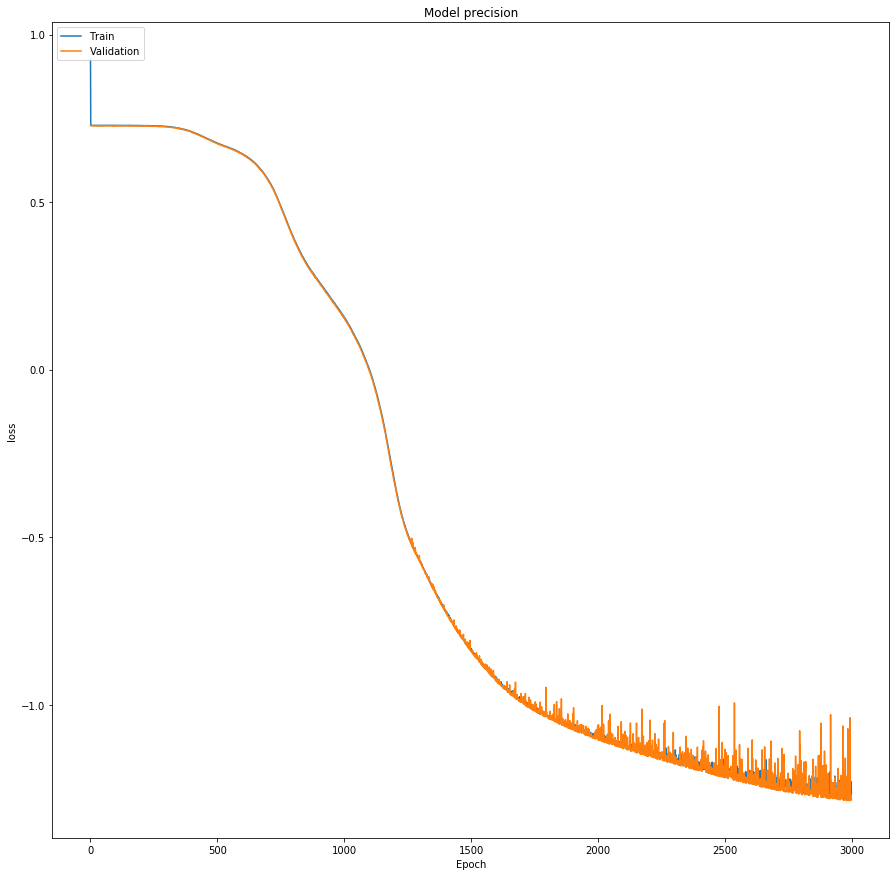

In [15]:
plt.figure(figsize=(15,15))
plt.plot(history_cache.history['loss'])
plt.plot(history_cache.history['val_loss'])
plt.title('Model precision')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')

Text(0.5, 0.92, 'R²: 0.9977828194280637')

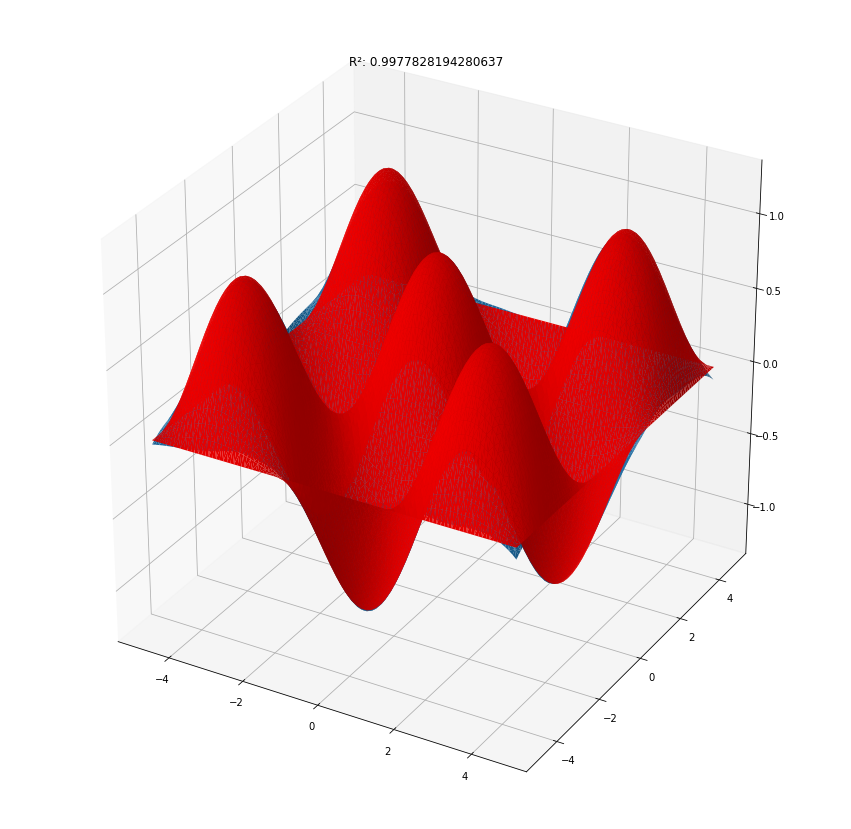

In [22]:
mu_pred, sigma_pred = model.predict(list((x_test_grid,x_test_grid[:,0]))) # the model expects a list of arrays as it has 2 inputs
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
pointesx, pointesy = generatePointsGaussian(100,1,0)
ax.plot_trisurf(x_test_grid[:,0],x_test_grid[:,1],mu_pred.reshape(mu_pred.shape[0],))
ax.plot_trisurf(x_test_grid[:,0],x_test_grid[:,1],originalFunction.reshape(originalFunction.shape[0],),color='r')
ax.set_zlim(-1.3,1.3)
r2 = r2_score(originalFunction,mu_pred[:,0])
ax.set_title("R²: "+ str(r2))